In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

from ts_pred_helper import *

/home/asuka/anaconda3/envs/py3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# demo data
# steps = 10000
# init_seq = np.array([1, 2, 3])
# weights = np.array([0.1001, 0.2, 0.7, 0.1])
# noise_func = gaussian_noise
# sim_data = ar_data_generator(init_seq, weights, noise_func, steps, normalize=True)
# data = sim_data[100:, None]
# plt.plot(data[:, 0])
# plt.show()

In [3]:
iterations = 3
model_names = ['FF', 'RNN', 'Transformer']
models = [FF(1, 3, 64), RNN(1, 64, 4, 1), Transformer(1, 64, 2, 4, 3)]
init_seq = np.array([1, 2, 3])
weights = np.array([0.1, 0.2, 0.7, 0.01])
noise_func = gaussian_noise

x_ticks = np.linspace(-5, 5, 20)
noise_factors = [10**x_tick for x_tick in x_ticks]


def train_and_save(idx):
    results = {}
    for noise_factor in tqdm(noise_factors):
        weights[-1] = noise_factor
        results[noise_factor] = []
        for i in range(iterations):
            set_seed(i+1)
            tys, pys = train_eval(models[idx], init_seq, weights, gaussian_noise, epochs=200)
            results[noise_factor].append((tys, pys))
    pickle_save(f'results/{model_names[idx]}_res.pkl', results)


def load_and_eval(idx, threhold):
    ff_res = pickle_load(f'results/{model_names[idx]}_res.pkl')
    x_ticks = []
    ys1 = []
    for key, res_list in ff_res.items():
        x_ticks.append(np.log10(key))
        cur_ys = []
        for value in res_list:
            tys, pys = value
            cur_y = rmse(pys, tys)
            if cur_y > threhold:
                cur_y = threhold
            cur_ys.append(cur_y)
        ys1.append(np.mean(cur_ys))
    return x_ticks, ys1


for idx in range(3):
    train_and_save(idx)

100%|██████████| 20/20 [02:33<00:00,  7.70s/it]


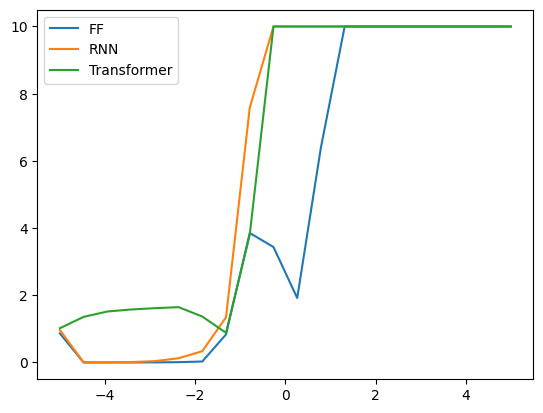

In [4]:
x_ticks = []
threhold = 10

for idx in range(3):
    x_ticks, ys1 = load_and_eval(idx, threhold)
    plt.plot(x_ticks, ys1, label=f'{model_names[idx]}')
plt.legend()
plt.show()